<a href="https://colab.research.google.com/github/roliveira15/Data_Science_Sales_Forecast/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1) Carregando as bibliotecas

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2) Importando o dataFrame

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


### 3) Importando Dataframe

In [119]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
#dateparse = lambda dates: pd.datetime.strptime(dates,'%d-%m-%Y') , parse_dates=['data'], index_col = 'data', date_parser=dateparse
df = pd.read_csv('https://raw.githubusercontent.com/roliveira15/Data_Science_Sales_Forecast/main/base.csv', sep = ';')
df.dtypes

tipo_frete                      object
peso                            object
valor_total_pedido              object
data                            object
abreviatura_uf                  object
regiao                          object
grupo_gerencial_produto         object
conta_numero_pedido_vendedor     int64
dtype: object

### 4) Converter o peso e o valor em float

Por padrão todas as variáveis do tipo string são armazenadas como object por esse motivo toda vez que tentamos modifcar de object para str, quando geramos o dtypes, as variáveis permanecem object. https://statisticsglobe.com/convert-object-data-type-string-pandas-dataframe-column-python





In [120]:

df['peso'] = df['peso'].str.replace(',','.').astype(float)
df['valor_total_pedido'] = df['valor_total_pedido'].str.replace(',','.').astype(float)

df['data'] = pd.to_datetime((df['data']))

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
dtype: object

###5) Criar uma coluna de Ano e mês

In [121]:
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
ano                                      int64
mes                                      int64
dtype: object

### 6) Criando estrutura para gerar gráfico de estruturas por ano, mes em função de peso e valor_total_pedido 

In [122]:
groupStructures = df.groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum()

groupStructures = groupStructures.round({'valor_total_pedido': 0,'peso': 0}).groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum().reset_index()
groupStructures.loc[(groupStructures['valor_total_pedido'] > 0) & (groupStructures['data'] >= '2020-09-01')]


,grupo_gerencial_produto,ano,mes,data,tipo_frete,regiao,abreviatura_uf,peso,valor_total_pedido,conta_numero_pedido_vendedor
3,AUTOMACAO,2020,9,2020-09-10,CIF,Sudeste,ES,1343.0,79000.0,1
5,AUTOMACAO,2020,11,2020-11-08,CIF,Sudeste,ES,811.0,56550.0,1
6,AUTOMACAO,2021,1,2021-01-04,CIF,Sudeste,ES,3830.0,333060.0,1
7,AUTOMACAO,2021,1,2021-01-05,CIF,Nordeste,RN,8845.0,610800.0,1
8,AUTOMACAO,2021,3,2021-03-08,CIF,Sudeste,SP,2542.0,2052312.0,1
...,...,...,...,...,...,...,...,...,...,...
4558,UNIVERSAL,2023,5,2023-05-15,FOB,Sudeste,ES,6628.0,10605.0,1
4559,UNIVERSAL,2023,6,2023-06-02,FOB,Sudeste,ES,8721.0,13954.0,1
4560,UNIVERSAL,2023,6,2023-06-04,FOB,Sudeste,ES,4955.0,7928.0,1
4561,UNIVERSAL,2023,7,2023-07-03,FOB,Sudeste,ES,8695.0,13912.0,1


6.1) Declara as variáveis principais do produto, data e região

In [123]:
PPint = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2024-01-01') & (groupStructures['regiao'] == 'Norte')]
PP = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2022-01-01') & (groupStructures['data'] < '2023-01-01') & (groupStructures['regiao'] == 'Norte')]
PPanterior = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2021-01-01') & (groupStructures['data'] < '2022-01-01') & (groupStructures['regiao'] == 'Norte')]
PPanteriorA = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2021-01-01') & (groupStructures['regiao'] == 'Norte')]

6.2) Criando gráfico por estrutura


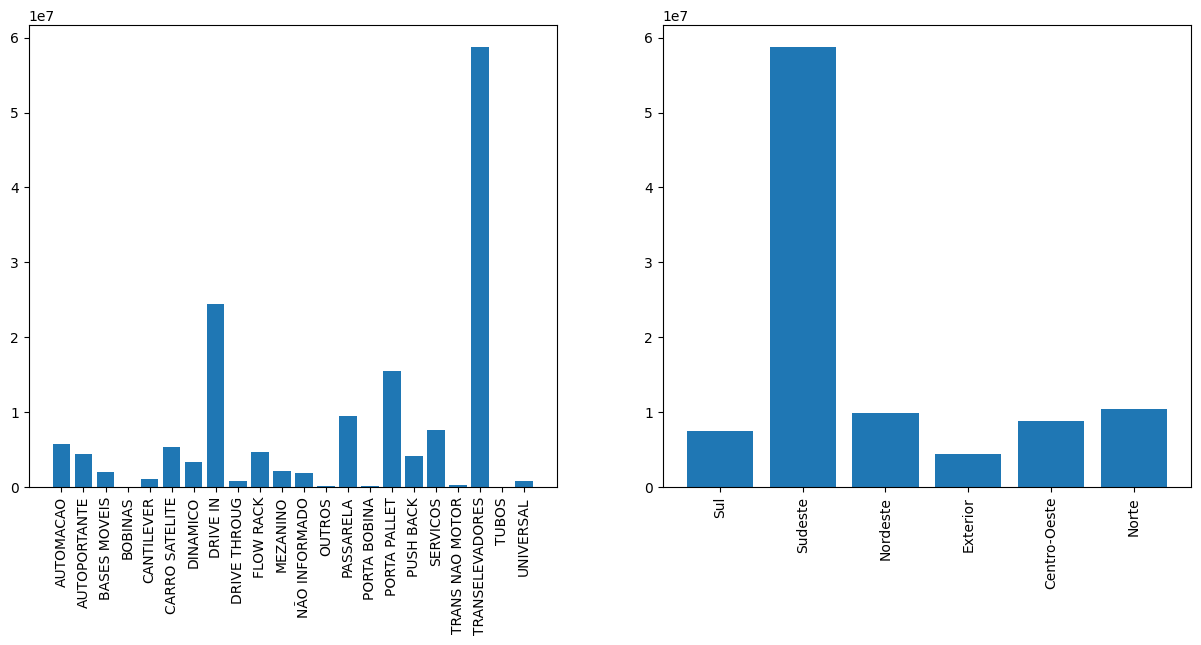

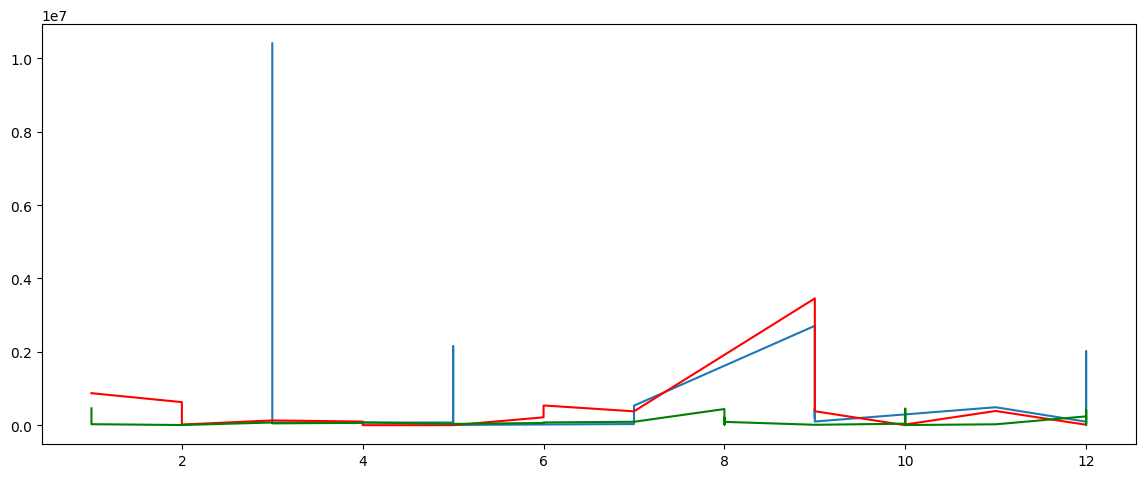

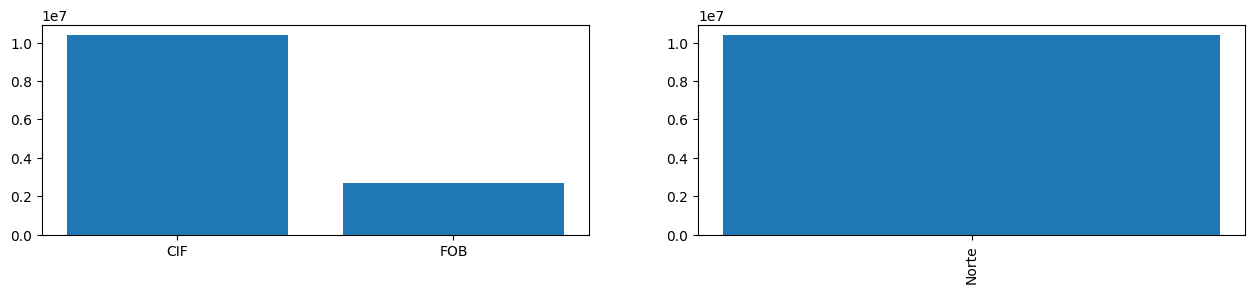

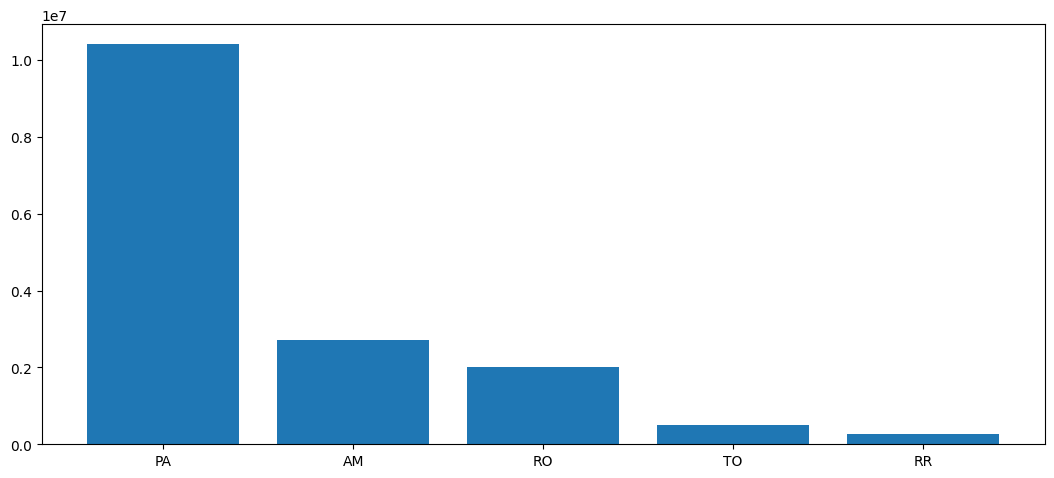

In [124]:

'''
                                  PORTA PALETE
'''
#Gráfico de barras de 
plt.figure(figsize = ((15, 6)))
plt.subplot(1, 2, 1)
plt.bar(groupStructures['grupo_gerencial_produto'], groupStructures['valor_total_pedido'])
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.bar(groupStructures['regiao'], groupStructures['valor_total_pedido'])
plt.xticks(rotation=90)

plt.figure(figsize = ((48, 12)))
#Anual
plt.subplot(2, 3, 3)
plt.plot(PP['mes'],PP['valor_total_pedido'])
plt.plot(PPanterior['mes'],PPanterior['valor_total_pedido'],color='red')
plt.plot(PPanteriorA['mes'],PPanteriorA['valor_total_pedido'],color='green')
plt.show()

plt.figure(figsize = ((24, 6)))
#Tipo de frete
plt.subplot(2, 3, 1)
plt.bar(PP['tipo_frete'], PP['valor_total_pedido'])
#Região
plt.subplot(2, 3, 2)
plt.bar(PP['regiao'], PP['valor_total_pedido'])
plt.xticks(rotation=90)
#Estado
plt.figure(figsize = ((44, 12)))
plt.subplot(2, 3, 4)
plt.bar(PP['abreviatura_uf'],PP['valor_total_pedido'])
plt.show()




Realizar a plotagem de todos os grupos para entender o comportadomento dos gráficos

In [141]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


modelo_preditivo = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2023-07-01') & (groupStructures['regiao'] == 'Norte')]
modelo_preditivo = modelo_preditivo.drop(columns=['ano','mes','peso','conta_numero_pedido_vendedor']).round({'valor_total_pedido': 0}).groupby(['data']).sum()
modelo_preditivo.index.names = ['data']
display(modelo_preditivo)


'''
plot_acf(PP['valor_total_pedido'])
plot_acf(PPanterior['valor_total_pedido']) 
plot_acf(PPanteriorA['valor_total_pedido']) 
plt.show()
'''

<ipython-input-141-bc3af7c3ffa2>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  modelo_preditivo = modelo_preditivo.drop(columns=['ano','mes','peso','conta_numero_pedido_vendedor']).round({'valor_total_pedido': 0}).groupby(['data']).sum()


,valor_total_pedido
data,
2020-01-24,458850.0
2020-01-28,27000.0
2020-02-17,4488.0
2020-03-19,73332.0
2020-03-25,49896.0
...,...
2023-01-16,489064.0
2023-03-05,43517.0
2023-03-23,474614.0


"\nplot_acf(PP['valor_total_pedido'])\nplot_acf(PPanterior['valor_total_pedido']) \nplot_acf(PPanteriorA['valor_total_pedido']) \nplt.show()\n"

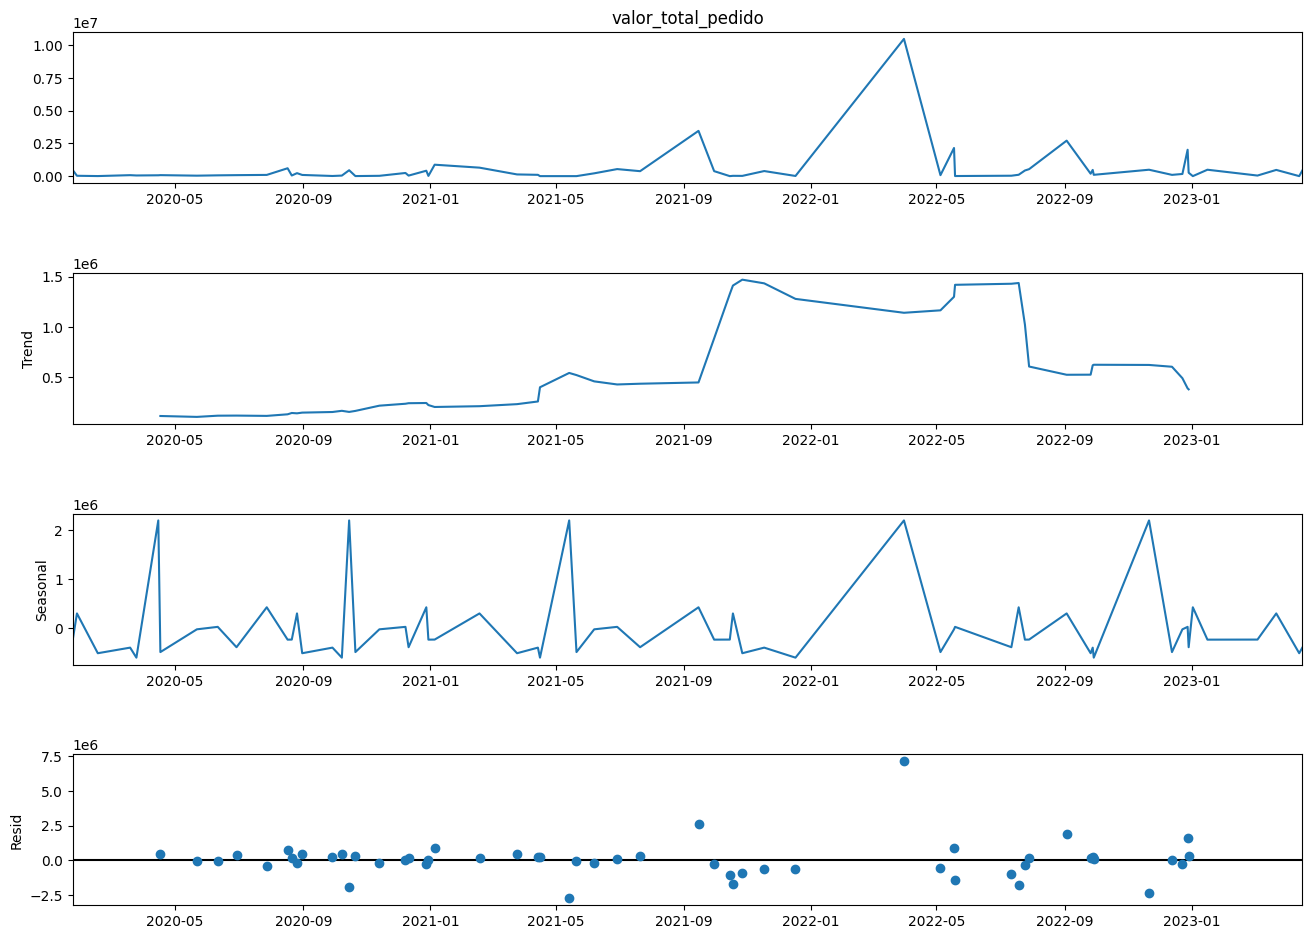

In [154]:

from statsmodels.tsa.seasonal import seasonal_decompose

#array = np.array(modelo_preditivo['valor_total_pedido'])

results = seasonal_decompose(x=modelo_preditivo['valor_total_pedido'],model='additive',period=12)

fig = results.plot()
fig.set_size_inches(13, 10)


In [143]:
! pip install pmdarima


from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


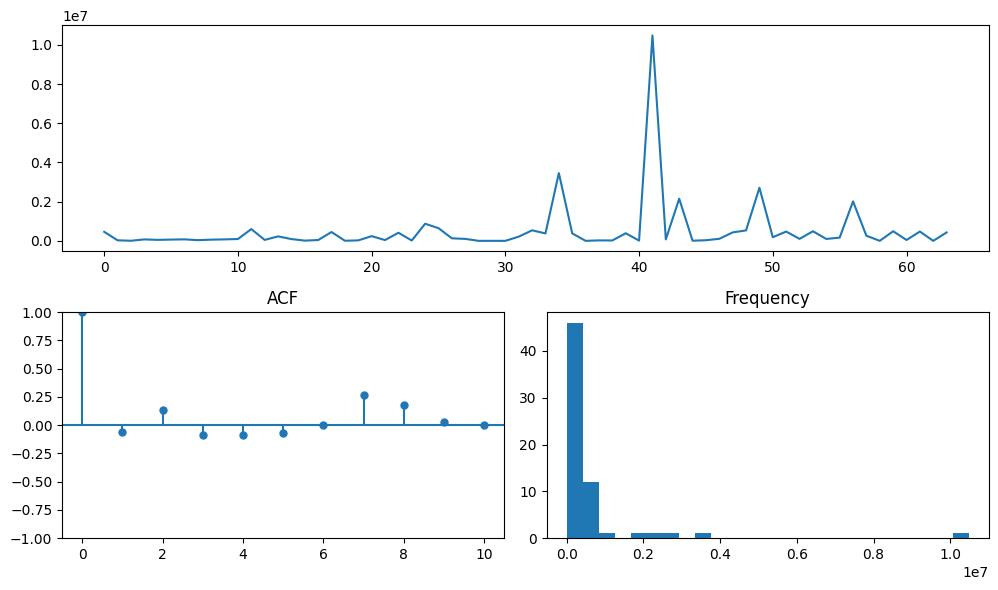

In [144]:
tsdisplay(modelo_preditivo,lag_max=10,figsize=(10,6))

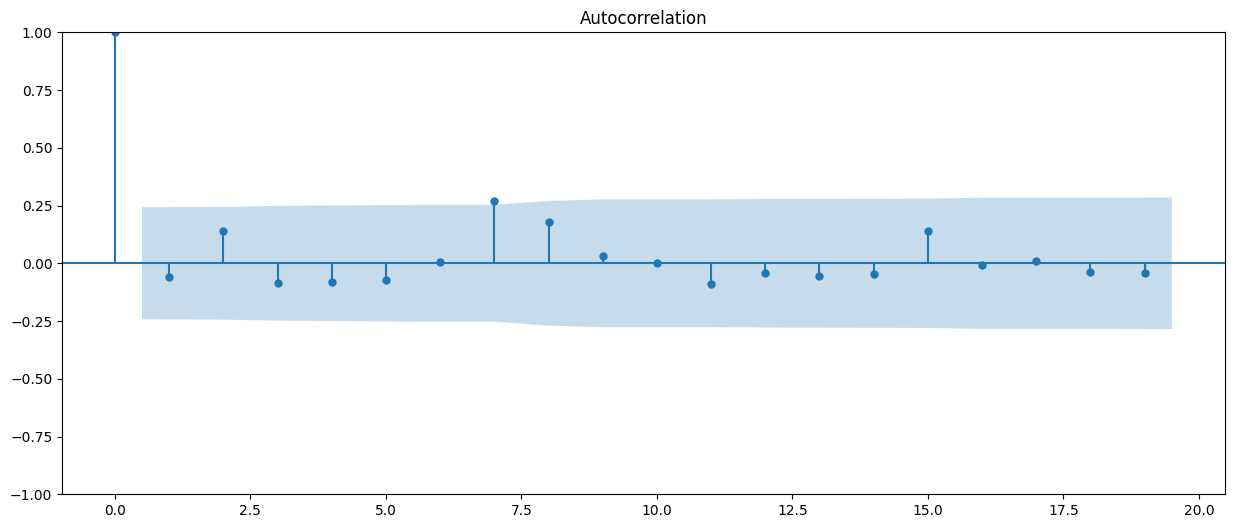

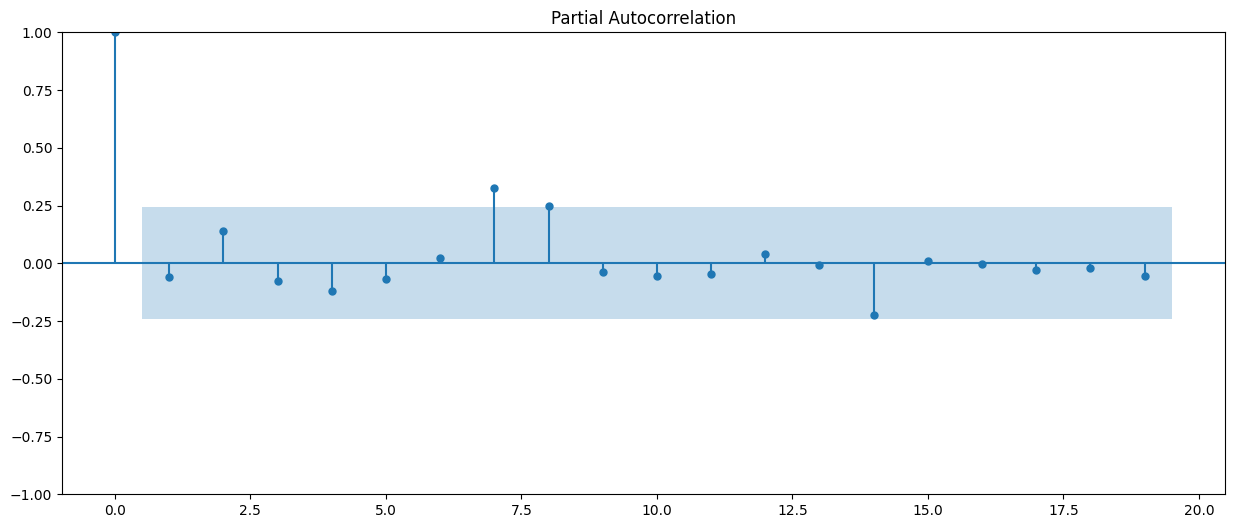

In [129]:
plot_acf(modelo_preditivo, alpha=0.05);
plot_pacf(modelo_preditivo, alpha=0.05);

In [130]:
stepwise=auto_arima(modelo_preditivo,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1681.307, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1702.841, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1687.290, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1702.057, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1683.355, Time=0.20 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=1682.318, Time=0.94 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=1683.285, Time=0.56 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1682.614, Time=0.32 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1681.359, Time=0.28 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=1684.169, Time=1.14 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1683.712, Time=0.48 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1685.310, Time=0.47 sec
 ARIMA(1,0,1)(1,1,1)[12] inte

In [131]:
stepwise

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True)

In [132]:
print(stepwise.aic())
print(stepwise.bic())

1681.3066151687826
1689.187782822991


In [133]:
PPtreino = modelo_preditivo.loc['2020-01-01':'2022-01-01']

PPtest = modelo_preditivo.loc['2022-01-01':]

PPtreino

,valor_total_pedido
data,
2020-01-24,458850.0
2020-01-28,27000.0
2020-02-17,4488.0
2020-03-19,73332.0
2020-03-25,49896.0
2020-04-15,63824.0
2020-04-17,75600.0
2020-05-22,35000.0
2020-06-11,60000.0


In [134]:
stepwise.fit(PPtreino)

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True)

In [135]:
previsao = stepwise.predict(n_periods=12)

display(previsao)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


41    4.148251e+05
42    1.201032e+05
43    2.184354e+05
44    4.853033e+05
45    2.904979e+05
46    1.730267e+06
47    2.487698e+05
48    6.961463e+05
49    5.451709e+05
50    2.092834e+05
51    3.368056e+05
52    1.240334e+05
dtype: float64

<Figure size 2000x500 with 0 Axes>

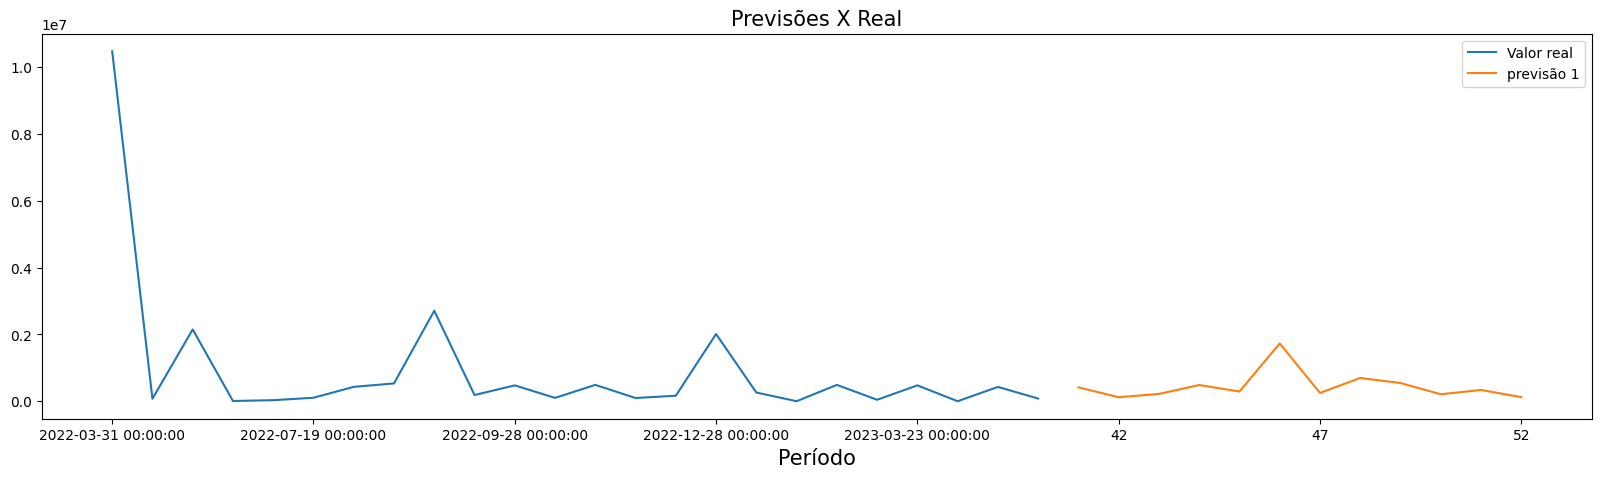

In [136]:
prevtessisao=pd.DataFrame(previsao,index=PPtest.index, columns=['previsão modelo 1'])
plt.figure(figsize=(20,5))
pd.concat([PPtest,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1','previsão 2']);





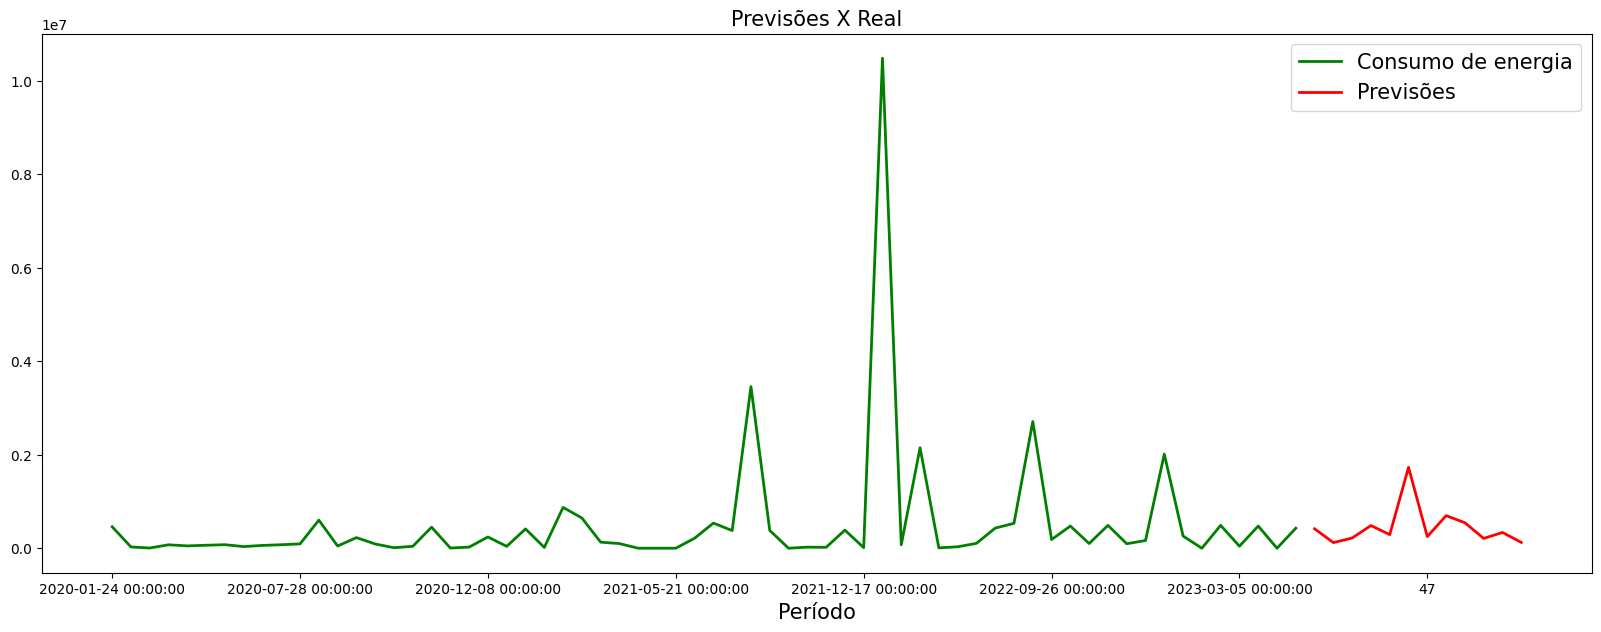

KeyError: ignored

In [155]:
pd.concat([modelo_preditivo,previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Consumo de energia','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();


In [150]:
previsao.stepwise_fit.plot_diagnostics(figsize=(15,10));

AttributeError: ignored